In [ ]:
import pandas as pd
from pathlib import Path
import sys
import numpy as np

sys.path.append(str(Path().resolve().parent))
from data_preprocessing.preprocessing import preprocessing
from eda_ftr_eng.EDA import eda
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [2]:
df_raw = pd.read_csv('../Data/Raw/Job_Frauds.csv', encoding='latin-1')
preprocessed_df = preprocessing(df_raw)

C:\Users\eilee\OneDrive - National University of Singapore\DSA4263\DSA4263-Project\data_preprocessing\preprocessing.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [3]:
preprocessed_df['Profile']

0        food52 weve created groundbreaking awardwinnin...
1        90 second world cloud video production service...
2        valor service provides workforce solution meet...
3        passion improving quality life geography heart...
4        spotsource solution llc global human capital m...
                               ...                        
17875    vend looking awesome new talent come join u yo...
17876    weblinc ecommerce platform service provider fa...
17877    provide full time permanent position many medi...
17878                                              unknown
17879    vend looking awesome new talent come join u yo...
Name: Profile, Length: 17880, dtype: object

In [4]:
df = eda(preprocessed_df)

In [5]:
df.columns

Index(['Job Title', 'Department', 'Range_of_Salary', 'Profile',
       'Job_Description', 'Requirements', 'Job_Benefits', 'Telecomunication',
       'Comnpany_Logo', 'Type_of_Employment', 'Experience', 'Qualification',
       'Type_of_Industry', 'Operations', 'Fraudulent', 'City',
       'Salary_Specified', 'City_Specified'],
      dtype='object')

## Encodoing + Embedding

In [7]:
from sentence_transformers import SentenceTransformer

columns_for_embedding = ['Job Title', 'Profile', 'Department', 'Job_Description', 'Requirements', 'Job_Benefits', 'Type_of_Industry', 'Operations','City']
categorical_columns = ['Type_of_Employment','Experience', 'Qualification' ]

model = SentenceTransformer('all-MiniLM-L6-v2')
df = df.reset_index(drop=True) #need to do this
for col in columns_for_embedding:
    print(f"Embedding column: {col}")
    df[f"{col}_embed"] = list(model.encode(df[col].fillna("")))

C:\Users\eilee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (None)/charset_normalizer (3.4.1) doesn't match a supported version!
  warnings.warn(


Embedding column: Job Title
Embedding column: Profile
Embedding column: Department
Embedding column: Job_Description
Embedding column: Requirements
Embedding column: Job_Benefits
Embedding column: Type_of_Industry
Embedding column: Operations
Embedding column: City


In [8]:
def simplify_qualification(q):
    if pd.isna(q) or q in ["unspecified", "other"]:
        return "unspecified"
    elif q in ["high school or equivalent", "some high school coursework", "vocational hs diploma"]:
        return "high school"
    elif q in ["vocational", "vocational degree", "certification", "professional"]:
        return "vocational / certification/ professional"
    elif q == "some college coursework completed":
        return "some college"
    elif q == "associate degree":
        return "associate degree"
    elif q == "bachelors degree":
        return "bachelor's degree"
    elif q == "masters degree":
        return "master's degree"
    elif q == "doctorate":
        return "doctorate"
    else:
        return "unspecified"

def simplify_employment_type(q):
    if pd.isna(q) or q in ["other", "unknown"]:
        return "unspecified"
    else:
        return q
    
def simplify_experience(q):
    if pd.isna(q) or q in ["not applicable", "unknown"]:
        return "unspecified"
    else:
        return q

df['Qualification'] = df['Qualification'].apply(simplify_qualification)
df['Type_of_Employment'] = df['Type_of_Employment'].apply(simplify_employment_type)
df['Experience'] = df['Experience'].apply(simplify_experience)

In [9]:
df_aft_str_embed = df.drop(columns_for_embedding, axis=1)

In [11]:
# One-Hot Encode
df_aft_enc = pd.get_dummies(df_aft_str_embed, columns=categorical_columns, drop_first=True)

# Get only the one-hot columns that actually exist in the final DataFrame
one_hot_encode_cols = [col for col in df_aft_enc.columns if any(col.startswith(cat + '_') for cat in categorical_columns)] #to be used later

In [12]:
df_aft_enc.columns

Index(['Range_of_Salary', 'Telecomunication', 'Comnpany_Logo', 'Fraudulent',
       'Salary_Specified', 'City_Specified', 'Job Title_embed',
       'Profile_embed', 'Department_embed', 'Job_Description_embed',
       'Requirements_embed', 'Job_Benefits_embed', 'Type_of_Industry_embed',
       'Operations_embed', 'City_embed', 'Type_of_Employment_fulltime',
       'Type_of_Employment_parttime', 'Type_of_Employment_temporary',
       'Type_of_Employment_unspecified', 'Experience_director',
       'Experience_entry level', 'Experience_executive',
       'Experience_internship', 'Experience_midsenior level',
       'Experience_unspecified', 'Qualification_bachelor's degree',
       'Qualification_doctorate', 'Qualification_high school',
       'Qualification_master's degree', 'Qualification_some college',
       'Qualification_unspecified',
       'Qualification_vocational / certification/ professional'],
      dtype='object')

In [ ]:
#Convert boolean type to integer
for col in df_aft_enc.columns:
    if df_aft_enc[col].dtype == 'bool':
        df_aft_enc[col] = df_aft_enc[col].astype(int)

#Scale Range of Salary
scaler = MinMaxScaler()
df_aft_enc['Range_of_Salary'] = scaler.fit_transform(df_aft_enc[['Range_of_Salary']])

## Feature Selection (for non-embedding features)

In [13]:
from collections import Counter 
from sklearn.feature_selection import * 
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, SelectFromModel 
from sklearn.linear_model import LogisticRegression, Lasso 
from sklearn.svm import LinearSVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
import matplotlib.pyplot as plt

In [14]:
embed_cols = []
for col in columns_for_embedding:
    embed_col_name = f"{col}_embed"
    embed_cols.append(embed_col_name)
non_embed_df = df_aft_enc.drop(embed_cols, axis=1).reset_index(drop=True)

In [ ]:
non_embed_df.head(5)

,Range_of_Salary,Telecomunication,Comnpany_Logo,Fraudulent,Salary_Specified,City_Specified,Type_of_Employment_fulltime,Type_of_Employment_parttime,Type_of_Employment_temporary,Type_of_Employment_unspecified,...,Experience_internship,Experience_midsenior level,Experience_unspecified,Qualification_bachelor's degree,Qualification_doctorate,Qualification_high school,Qualification_master's degree,Qualification_some college,Qualification_unspecified,Qualification_vocational / certification/ professional
0,4000070000,0,1,0,False,True,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False
1,4000070000,0,1,0,False,True,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False
2,4000070000,0,1,0,False,True,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False
3,4000070000,0,1,0,False,True,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False
4,4000070000,0,0,0,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10651,4000070000,0,1,0,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
10652,4000070000,0,1,0,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
10653,80000100000,0,0,0,True,False,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False
10654,4000070000,0,1,0,False,True,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False


In [16]:
def convert_scores_to_df(features: list[str], scores: list[float]) -> pd.DataFrame: 
    """Convert the feature & scores list to dataframe and round of the score to 3 decimal places 
 
    Args: 
        features (list[str]): Feature names 
        scores (list[float]): Score for respective features 
 
    Returns: 
        score_df (pd.Dataframe) 
    """ 
    return pd.DataFrame({'features':features,'scores':scores}).sort_values(by='scores',ascending=False).reset_index(drop=True).round(3)

In [ ]:
def select_rfe_with_class_weights(features: pd.DataFrame, labels: pd.DataFrame, top_k: int = 20)-> dict[str, any]: 
    """ 
    Selects the top K features using Recursive Feature Elimination (RFE) with class weights adjusted. 
 
    Pros: Addresses class imbalance; interpretable 
    Cons: Computationally intensive for large datasets 
 
    Args: 
        features (pd.DataFrame): Feature Dataframe (X). 
        labels (pd.DataFrame): Labels Dataframe (Y). 
        top_k (int, optional): Top K Features to return from Features Dataframe. Defaults to 20. 
 
    Returns: 
       dict[str, any]: List of the top K feature names. 
    """ 
    model = LogisticRegression(class_weight='balanced') 
    rfe = RFE(model, n_features_to_select=top_k) 
    rfe.fit(features, labels) 
    rank_df = convert_scores_to_df (features.columns, rfe.ranking_) 
    #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1. 
    top_k_df = rank_df[rank_df['scores'] == 1] 
    top_k_features = top_k_df['features'].values 
    return { 
        'method': 'Recursive Feature Elimination (rankings) - Class Balanced', 
        'top_k_features': top_k_features, 
        'score_df': top_k_df 
        } 

def select_random_forest(features: pd.DataFrame, labels: pd.DataFrame, top_k: int = 20)-> dict[str, any]: 
    """ 
    Selects the top K features using Random Forest feature importance. 
 
    Pros: Robust to overfitting; handles high-dimensional data 
    Cons: Computationally expensive; may not be as interpretable 
 
    Args: 
        features (pd.DataFrame): Feature Dataframe (X). 
        labels (pd.DataFrame): Labels Dataframe (Y). 
        top_k (int, optional): Top K Features to return from Features Dataframe. Defaults to 20. 
 
    Returns: 
        dict[str, any]: List of the top K feature names. 
    """ 
    model = RandomForestClassifier() 
    model.fit(features, labels) 
    # selector = SelectFromModel(model, max_features=top_k, prefit=True) 
    score_df = convert_scores_to_df (features.columns, model.feature_importances_)   
    top_k_features = score_df.head(top_k)['features'].values 
    return { 
        'method': 'RandomForest', 
        'top_k_features': top_k_features, 
        'score_df': score_df.head(top_k) 
        } 

In [ ]:
def feature_selection(data, features, model_name, k):
    if model_name == "select_rfe_with_class_weights": model = select_rfe_with_class_weights
    elif model_name == "select_random_forest": model = select_random_forest
    else: print("No such model")
    
    model_results = model(data[features], data['Fraudulent'], top_k = k) #k: number of features selected by the model
    selected_features = model_results['top_k_features']
    top_k_df = model_results['score_df']
    top_k_df.sort_values(by='scores',ascending=True).plot.barh(y='scores',x='features')
    # print(top_k_df)
    plt.show()
    return top_k_df, selected_features

In [ ]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = non_embed_df

y = data['Fraudulent']
x_vif = data.drop(['Fraudulent'], axis=1)
thres = 10

while True:
    Cols = range(x_vif.shape[1])
    vif = np.array([variance_inflation_factor(x_vif.values, i) for i in Cols])
    
    if all(vif < thres):
        break
    else:
        max_vif_idx = np.argmax(vif)
        col_to_drop = x_vif.columns[max_vif_idx]
        print(f"Dropping column '{col_to_drop}' with VIF = {vif[max_vif_idx]:.2f}")
        x_vif = x_vif.drop(columns=[col_to_drop])
        
x_vif['Fraudulent'] = y

x_vif

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

data = x_vif
y = data['Fraudulent']
X = data.drop(columns=['Fraudulent'])


model = RandomForestClassifier(random_state=42, class_weight='balanced')

k_range = range(1, X.shape[1])
cv_scores = []
cv_scores_per_k = []

for k in k_range:
    print(f"Currently doing {k} number of features")
    rfe = RFE(estimator=model, n_features_to_select=k)
    X_rfe = rfe.fit_transform(X, y)
    
    score = cross_val_score(model, X_rfe, y, cv=5, scoring='f1').mean()
    cv_scores.append(score)
    cv_scores_per_k.append(score/k)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("RFE: F1 Score vs. Number of Features")
plt.grid(True)
plt.show()

# Best k
best_k = k_range[cv_scores.index(max(cv_scores))]
print(f"Best k = {best_k}, F1 Score = {max(cv_scores):.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_range, cv_scores_per_k, marker='o')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("RFE: F1 Score per k vs. Number of Features")
plt.grid(True)
plt.show()



In [ ]:
from kneed import KneeLocator

# Convert range to list if it's a range object
k_values = list(k_range)

# Detect elbow (knee) point
knee = KneeLocator(k_values, cv_scores_per_k, curve="convex", direction="decreasing")

print("Optimal number of features (elbow point):", knee.knee)

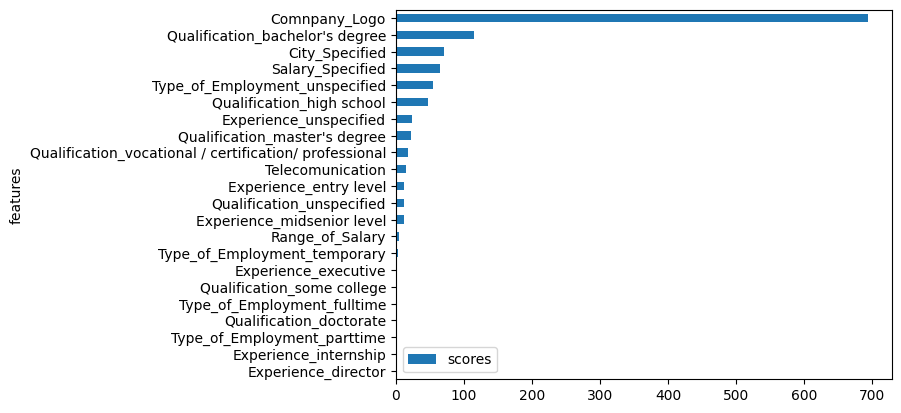

In [ ]:
features = x_vif.drop(['Fraudulent'], axis=1).columns

score_df_k_best, selected_ftrs_k = feature_selection(x_vif, features, "select_rfe_with_class_weights", knee.knee)

In [ ]:
embed_cols = []
for col in columns_for_embedding:
    embed_col_name = f"{col}_embed"
    embed_cols.append(embed_col_name)
    
selected_features = selected_ftrs_k.tolist() + embed_cols + ["Fraudulent"]
result_df = df_aft_enc[selected_features] 

In [ ]:
result_df.head(5)

,Comnpany_Logo,Range_of_Salary,Qualification_bachelor's degree,Salary_Specified,Type_of_Employment_unspecified,Qualification_high school,City_Specified,Experience_entry level,Experience_unspecified,Qualification_master's degree,...,Type_of_Employment_parttime,Job Title_embed,Profile_embed,Department_embed,Job_Description_embed,Requirements_embed,Job_Benefits_embed,Type_of_Industry_embed,Operations_embed,City_embed
0,1,0.000064,False,False,True,False,True,False,False,False,...,False,"[-0.04586085, 0.021231128, 0.039720006, -0.015...","[0.007577374, -0.07537833, -9.8881275e-05, -0....","[-0.054775894, 0.019262953, -0.028039964, 0.00...","[-0.042812638, -0.045987554, 0.035323277, 0.04...","[0.052500658, -0.070368946, 0.017132213, 0.077...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.054775853, 0.019262934, -0.028039932, 0.00...","[0.08636307, -0.019883374, 0.07149367, 0.04881..."
1,1,0.000064,False,False,True,False,True,False,True,False,...,False,"[-0.11712626, 0.0027783138, -0.012937445, 0.04...","[-0.1038746, -0.02861453, -0.017522436, -0.033...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.05678049, -0.005341466, 0.042253576, 0.022...","[0.005357014, -0.014099901, -0.018397406, -0.0...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.0861143, 0.02202922, 0.013500422, -0.03086..."
2,1,0.000064,True,False,False,False,True,False,False,False,...,False,"[0.004596934, 0.00481806, 0.05610048, -0.01695...","[0.033601683, 0.026707603, 0.032456033, -0.040...","[-0.059985198, 0.050252017, -0.033883702, 0.00...","[0.06790775, -0.035601683, -0.038815018, -0.01...","[0.05845114, -0.06939346, 0.0088499775, 0.0245...","[0.054842476, -0.026177054, 0.0051394845, 0.06...","[-0.07639078, 0.014425086, 0.0076301806, -0.05...","[-0.05998523, 0.050251998, -0.03388371, 0.0089...","[0.029875163, 0.07295453, 0.041961834, 0.06192..."
3,1,0.000064,True,False,False,False,True,False,False,False,...,False,"[-0.07773007, 0.04425555, -0.09833856, 0.03637...","[-0.06868328, -0.10022874, -0.029904751, 0.030...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.061310172, -0.041416116, -0.001455977, 0.0...","[-0.044740494, -0.06803957, -0.004668441, 0.06...","[-0.0093000075, 0.11122224, 0.020650487, -0.05...","[-0.024020242, 0.07457424, 0.016253611, 0.0282...","[-0.08913746, 0.0687411, 0.037631392, 0.007960...","[0.06753678, -0.014432617, -0.051255446, 0.093..."
4,0,0.000064,False,False,True,False,False,False,True,False,...,False,"[-0.07389787, 0.08476279, -0.07173842, -0.0072...","[-0.043102726, 0.06563697, -0.067522585, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.03573317, 0.024254303, -0.013907412, -0.00...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.010108454, 0.00017395255, -0.06452543, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10651,1,0.000064,False,False,False,False,True,False,True,False,...,False,"[-0.059665065, -0.06973596, 0.015686536, -0.03...","[-0.053581025, -0.04184387, -0.08866353, 0.002...","[-0.009457731, -0.059389398, -0.0023150004, -0...","[-0.010454145, -0.03652126, -0.03432445, -0.00...","[-0.030484734, -0.036128752, -0.008040969, 0.0...","[0.008699675, 0.012578782, 0.059729133, -0.044...","[-0.015799413, -0.020690944, 0.007293136, -0.0...","[0.0023448162, -0.049374875, 0.000757973, -0.0...","[0.12464663, 0.044928372, 0.054049045, 0.05528..."
10652,1,0.000064,False,False,False,False,True,False,True,False,...,False,"[-0.083389156, -0.027561797, -0.053467147, 0.0...","[-0.043102726, 0.06563697, -0.067522585, 0.074...","[-0.043102708, 0.06563704, -0.067522645, 0.074...","[-0.08936357, -0.01571605, -0.002595218